# AMATERASU tutorial

In this notebook, I will briefly explain how AMATERASU works and how to run it.

## What is AMATERASU?

AMATERASU (AutoMATic Equivalent-width Retrieval for Activity Signal Unveiling) is a simple Python tool to check for periods in spectral activity indices similar to an input period. This way, by running AMATERASU for a spectral line, the user can see if the input period may be correlated with activity. It's important to note that AMATERASU follows a methodology similar to the one described in Gomes da Silva et al. 2025 (in prep) and is heavily inspired by ACTIN2.

## How does AMATERASU work?

AMATERASU computes the equivalent width (EW) of a spectral line in a normalization independent way, by using the 90th percentile of the flux in a given window as the continuum level. It computes the EW for an array of bandpasses, going from 0.1 $\AA$ up to a user defined width.

This way, the input includes the spectral line center, bandpass width and a window that includes both the line and some continuum. By default, the flux is interpolated inside the window, with a step similar to the original spectrum's step. The maximum bandpass and the interpolation window can be given manually or automatically. Automatically, the spectra are coadded and then the code uses the find_peaks function of scipy to find spectral lines in a given order and then retrieves the FWHM of the closest line to be studied (threshold of 0.1 A). The bandpass window is a multiple (rounded) of the FWHM retrieved (by default 4 times) and the interpolation window is triple that (12 times the FWHM).

Having retrieved a time series of EWs measurements for a given bandpass, AMATERASU cleans the data by 3-sigma sequential clipping and binning the data by night. 

Finally, AMATERASU runs GLS periodograms (with a bunch of technicalities) and if the significant peak with most power is similar to the tested/input period, the program warns the user.

The user can choose one of the predefined indices in the ``ind_table.csv`` table or define a new indice.

Accepts a list of input periods and a list of lines to analyse.
Accepts both 1D and 2D spectra.

Besides the GLSPs, AMATERASU can compute the correlation of all the central bandpasses with an input array, that can be a known activity indice. It then prints the bandpass that maximizes correlation (positive or negative).

Output options:
    - Standard: warns if some input period was detect, in which line and with which FAP. Prints and saves a dataframe.
    - Full: saves all analysis data in a directory.

## Caveats and future upgrades

Caveats:
- AMATERASU was tested using NIRPS spectra only, so the predefined indices are NIR lines.
- AMATERASU was only tested with spectral lines that were more or less simmetrical and with a decent depth, so spectral lines like He I 10830 $\AA$ or Paschen $\beta$ were not considered.
- Interp_win should be big enough to not include flux from the line. If not calibrated the signal detected through GLSPs can be degraded and starts raising the year/2 signal.

Future upgrades:
- Include option to convert the wavelength to RV space.

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt #type: ignore
import matplotlib.colors as mcolors # type: ignore

from SpecFunc import SpecFunc
SpecFunc = SpecFunc()

from AMATERASU import AMATERASU

The indice table contains 11 spectral lines predefined: 3 of K I, 3 of Ti I, 2 of Al I, 2 of Mn I and 1 of Fe I. The interpolation windows were defined as double the maximum EW window, but this is not mandatory.

In [3]:
ind_table = pd.read_csv("ind_table.csv")
ind_table

ln_id     ln_ctr  ln_win  interp_win
0   AlIa  13127.011     5.0          10
1   AlIb  13154.345     5.0          10
2    FeI  11693.408     2.5           5
3    KIa  11772.862     2.0           4
4    KIb  12435.647     5.0          10
5    KIc  12525.544     5.0          10
6   MnIa  12903.289     2.5           5
7   MnIb  13322.609     2.0           4
8   TiIa  10498.989     1.5           3
9   TiIb  12825.181     1.5           3
10  TiIc  12850.545     1.5           3

Let's run AMATERASU for the star GJ 551 and the spectral line K I (c). The input period will be a literature rotation period value, the tolerance will be 10% of the aforementioned value and the FAP threshold for detection is 0.1%.

To run AMATERASU I also need to give the files (spectra) paths, the star ID, the name of the activity indice, the path to save some plots, and other parameters that were omitted in this tutorial.

In [4]:
star = "GJ551"

#gather spectra
_, files = SpecFunc._gather_spectra(star_name=star, instrument="NIRPS",type="2d")

spectra_observations = []
bjd_observations = np.zeros((len(files)))

fwhm_array = np.zeros((len(files)))
fwhm_err_array = np.zeros((len(files)))

for i, file in enumerate(files):

    spectrum_raw, header_raw = SpecFunc._Read(file, mode="vac")
    spectrum, header = SpecFunc._RV_correction(spectrum_raw, header_raw)

    spectra_observations.append([spectrum["wave"], spectrum["flux"], spectrum["flux_error"]])

    bjd_observations[i] = header["bjd"]

    fwhm_array[i] = header["fwhm"]
    fwhm_err_array[i] = header["fwhm_err"]

spectra_observations = np.array(spectra_observations, dtype=object) 
spectra_observations.shape

(137, 3, 71, 4084)

## Running AMATERASU

In [5]:
#options for AMATERASU

data = [bjd_observations,spectra_observations]


run_gls = True
period_test = [[80,5],[85,8]]
ptol = 10
fap_treshold = 0.001
plot_gls=True
gls_options = [run_gls, period_test, ptol, fap_treshold, plot_gls]


run_correlation=True
df_input = pd.DataFrame({"BJD":bjd_observations,"fwhm":fwhm_array,"fwhm_err":fwhm_err_array})
cols_input = ["fwhm"]
cols_err_input = ["fwhm_err"]
abs_corr_threshold=0.4
pval_threshold=0.001
correlation_options = [run_correlation, df_input, cols_input, cols_err_input, abs_corr_threshold, pval_threshold]


indices = ["KIa","KIb","KIc"]

indice_info = {"KIa":{'ln_ctr':11772.862},
               "KIb":{'ln_ctr':12435.647},
               "KIc":{'ln_ctr':12525.544},
               }


For a standard very summarised run of AMATERASU.

In [6]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options,output="standard", folder_path=None)

AMATERASU instance created for GJ551
--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KIa
Line center: 11772.862
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 2.1
Interpolation window: 6.3
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:07<00:00, 19.34it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 21/21 [00:00<00:00, 103.32it/s]


    bandpass  period           FAP input_period
0        0.1  79.866  5.645061e-18     [80, 85]
1        0.2  81.599  4.529832e-12     [80, 85]
2        0.3  86.280  3.194856e-04     [80, 85]
3        0.4  75.838  1.157949e-04     [80, 85]
4        0.5  77.400  4.465472e-12     [80, 85]
5        0.6  78.204  5.636585e-15     [80, 85]
6        0.7  78.204  9.158685e-17     [80, 85]
7        0.8  79.026  1.700533e-17     [80, 85]
8        0.9  79.026  8.672093e-18     [80, 85]
9        1.0  79.026  3.936695e-18     [80, 85]
10       1.1  79.026  3.437074e-18     [80, 85]
11       1.2  79.026  8.067383e-19     [80, 85]
12       1.3  79.026  8.179948e-19     [80, 85]
13       1.4  79.026  5.440444e-19     [80, 85]
14       1.5  79.026  7.662803e-19     [80, 85]
15       1.6  79.026  2.466214e-19     [80, 85]
16       1.7  79.026  9.104047e-20     [80, 85]
17       1.8  79.048  1.422391e-21     [80, 85]
18       1.9  79.048  1.813421e-21     [80, 85]
19       2.0  79.048  2.387919e-21     [

100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 45/45 [00:00<00:00, 103.23it/s]


    bandpass  period           FAP input_period
0        0.1  79.048  3.710427e-19     [80, 85]
1        0.2  79.866  9.835207e-19     [80, 85]
2        0.3  84.345  4.857001e-12     [80, 85]
3        0.4  82.494  2.317856e-11     [80, 85]
4        0.5  86.280  2.063706e-08     [80, 85]
5        0.6  91.531  2.099527e-07         [85]
6        0.7  93.846  4.936374e-06         [85]
7        0.9  78.226  2.036082e-08     [80, 85]
8        1.0  78.226  1.150237e-09     [80, 85]
9        1.1  79.048  1.173182e-11     [80, 85]
10       1.2  79.048  2.582922e-13     [80, 85]
11       1.3  79.048  1.098755e-13     [80, 85]
12       1.4  79.048  2.972746e-14     [80, 85]
13       1.5  79.048  1.301191e-15     [80, 85]
14       1.6  79.048  8.844187e-16     [80, 85]
15       1.7  79.048  1.127980e-16     [80, 85]
16       1.8  79.048  2.891502e-17     [80, 85]
17       1.9  79.048  4.411234e-17     [80, 85]
18       2.0  79.888  4.408336e-17     [80, 85]
19       2.1  79.048  1.802051e-17     [

100%|██████████| 137/137 [00:20<00:00,  6.54it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 60/60 [00:00<00:00, 91.91it/s]


    bandpass  period           FAP input_period
0        0.1  79.026  1.572356e-16     [80, 85]
1        0.2  79.866  3.859716e-12     [80, 85]
2        0.3  81.599  1.483670e-08     [80, 85]
3        0.5  77.400  3.520480e-04     [80, 85]
4        0.6  78.204  1.055467e-08     [80, 85]
5        0.7  78.204  3.407131e-12     [80, 85]
6        0.8  79.026  5.098070e-14     [80, 85]
7        0.9  79.026  1.191213e-15     [80, 85]
8        1.0  79.026  8.164853e-18     [80, 85]
9        1.1  79.026  7.826798e-19     [80, 85]
10       1.2  79.026  6.307572e-19     [80, 85]
11       1.3  79.026  8.018339e-19     [80, 85]
12       1.4  79.026  1.400523e-18     [80, 85]
13       1.5  79.026  3.742592e-19     [80, 85]
14       1.6  79.026  1.767512e-19     [80, 85]
15       1.7  79.048  1.269120e-20     [80, 85]
16       1.8  79.048  9.489849e-21     [80, 85]
17       1.9  79.048  1.057499e-20     [80, 85]
18       2.0  79.048  6.257153e-21     [80, 85]
19       2.1  79.048  1.188643e-20     [

Or for a full output:

AMATERASU instance created for GJ551


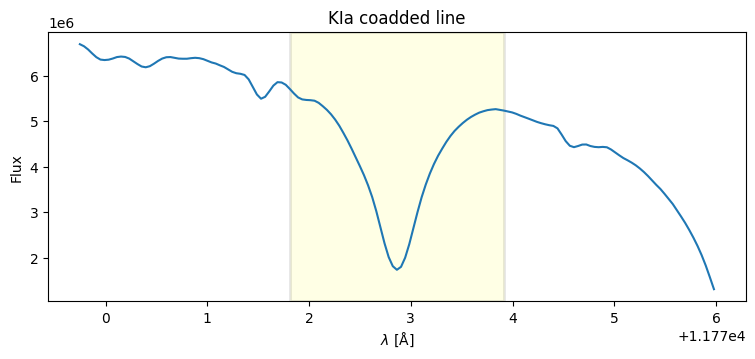

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KIa
Line center: 11772.862
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 2.1
Interpolation window: 6.3
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:07<00:00, 17.36it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


    bandpass  period           FAP input_period
0        0.1  79.866  5.645061e-18     [80, 85]
1        0.2  81.599  4.529832e-12     [80, 85]
2        0.3  86.280  3.194856e-04     [80, 85]
3        0.4  75.838  1.157949e-04     [80, 85]
4        0.5  77.400  4.465472e-12     [80, 85]
5        0.6  78.204  5.636585e-15     [80, 85]
6        0.7  78.204  9.158685e-17     [80, 85]
7        0.8  79.026  1.700533e-17     [80, 85]
8        0.9  79.026  8.672093e-18     [80, 85]
9        1.0  79.026  3.936695e-18     [80, 85]
10       1.1  79.026  3.437074e-18     [80, 85]
11       1.2  79.026  8.067383e-19     [80, 85]
12       1.3  79.026  8.179948e-19     [80, 85]
13       1.4  79.026  5.440444e-19     [80, 85]
14       1.5  79.026  7.662803e-19     [80, 85]
15       1.6  79.026  2.466214e-19     [80, 85]
16       1.7  79.026  9.104047e-20     [80, 85]
17       1.8  79.048  1.422391e-21     [80, 85]
18       1.9  79.048  1.813421e-21     [80, 85]
19       2.0  79.048  2.387919e-21     [

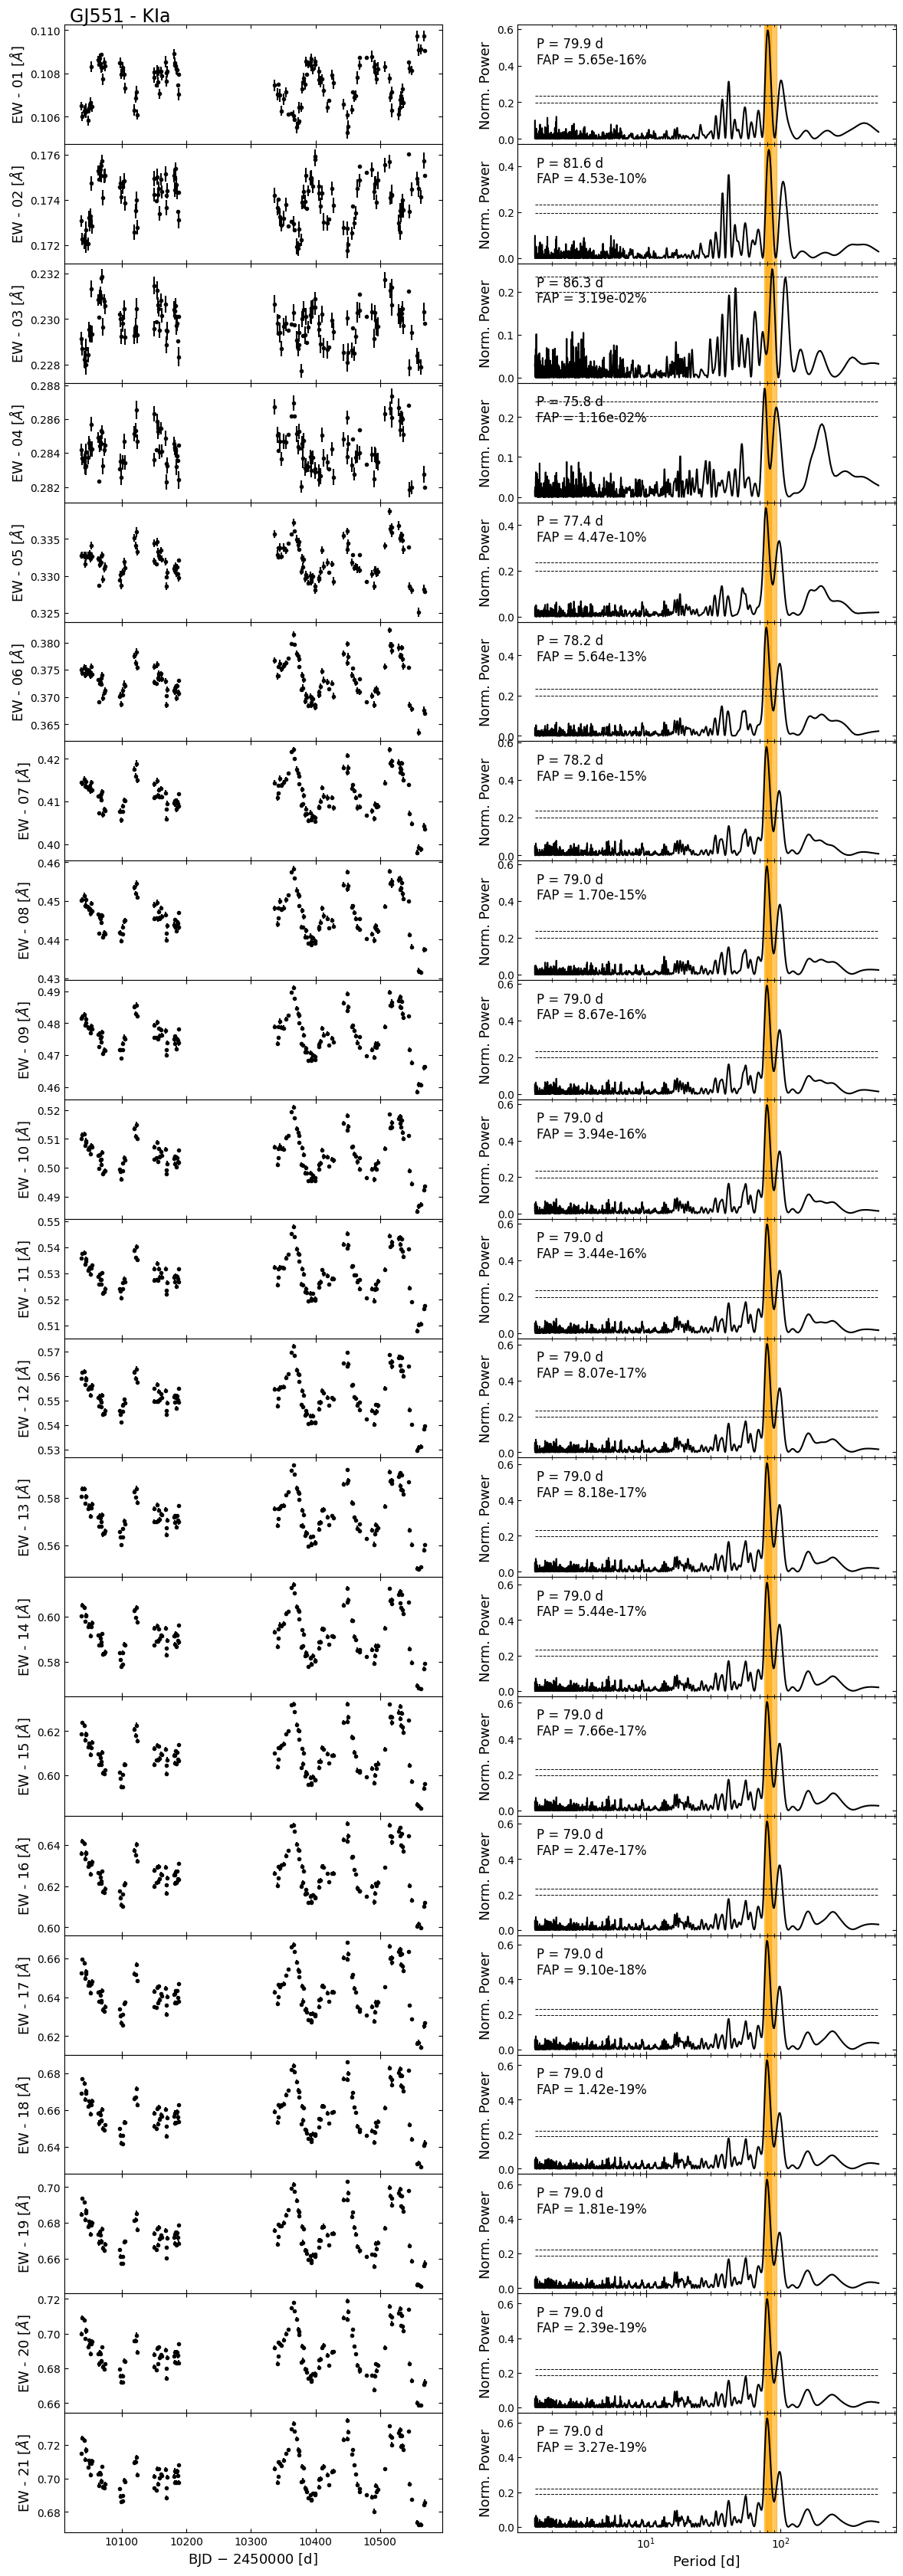

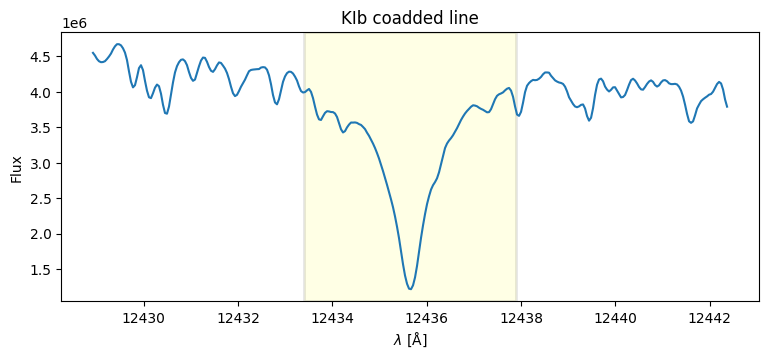

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KIb
Line center: 12435.647
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 4.5
Interpolation window: 13.5
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:16<00:00,  8.33it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 45/45 [00:57<00:00,  1.27s/it]


    bandpass  period           FAP input_period
0        0.1  79.048  3.710427e-19     [80, 85]
1        0.2  79.866  9.835207e-19     [80, 85]
2        0.3  84.345  4.857001e-12     [80, 85]
3        0.4  82.494  2.317856e-11     [80, 85]
4        0.5  86.280  2.063706e-08     [80, 85]
5        0.6  91.531  2.099527e-07         [85]
6        0.7  93.846  4.936374e-06         [85]
7        0.9  78.226  2.036082e-08     [80, 85]
8        1.0  78.226  1.150237e-09     [80, 85]
9        1.1  79.048  1.173182e-11     [80, 85]
10       1.2  79.048  2.582922e-13     [80, 85]
11       1.3  79.048  1.098755e-13     [80, 85]
12       1.4  79.048  2.972746e-14     [80, 85]
13       1.5  79.048  1.301191e-15     [80, 85]
14       1.6  79.048  8.844187e-16     [80, 85]
15       1.7  79.048  1.127980e-16     [80, 85]
16       1.8  79.048  2.891502e-17     [80, 85]
17       1.9  79.048  4.411234e-17     [80, 85]
18       2.0  79.888  4.408336e-17     [80, 85]
19       2.1  79.048  1.802051e-17     [

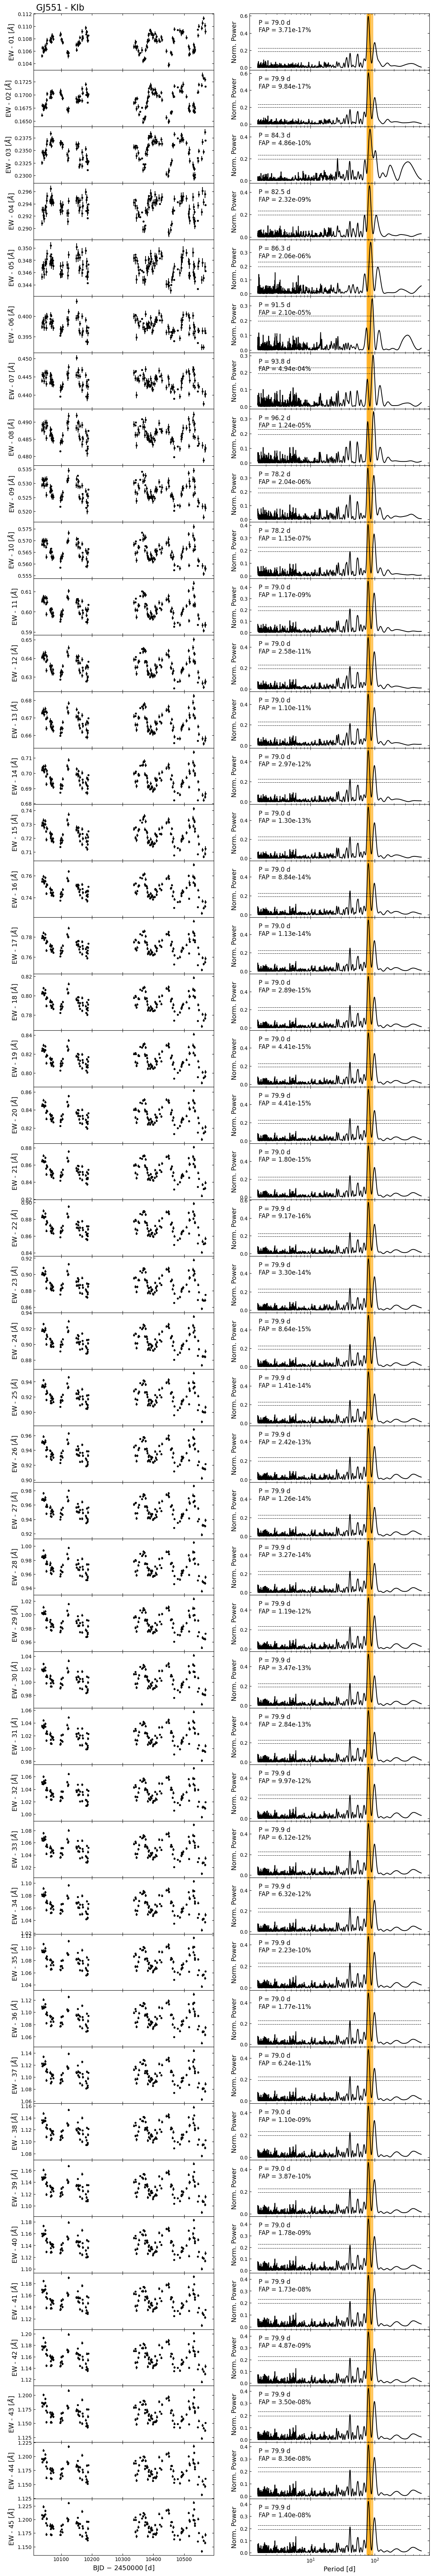

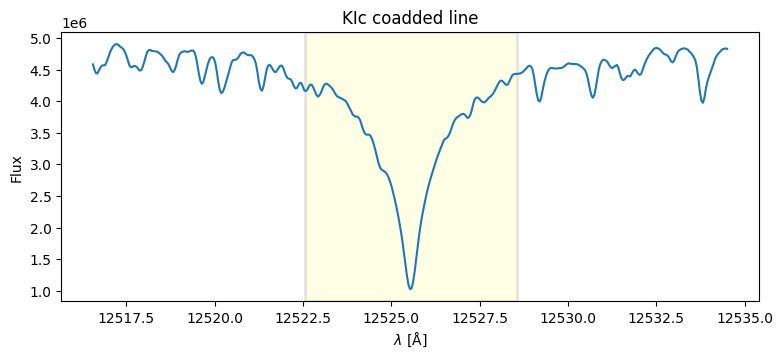

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KIc
Line center: 12525.544
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 6.0
Interpolation window: 18.0
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:23<00:00,  5.95it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 60/60 [01:29<00:00,  1.49s/it]


    bandpass  period           FAP input_period
0        0.1  79.026  1.572356e-16     [80, 85]
1        0.2  79.866  3.859716e-12     [80, 85]
2        0.3  81.599  1.483670e-08     [80, 85]
3        0.5  77.400  3.520480e-04     [80, 85]
4        0.6  78.204  1.055467e-08     [80, 85]
5        0.7  78.204  3.407131e-12     [80, 85]
6        0.8  79.026  5.098070e-14     [80, 85]
7        0.9  79.026  1.191213e-15     [80, 85]
8        1.0  79.026  8.164853e-18     [80, 85]
9        1.1  79.026  7.826798e-19     [80, 85]
10       1.2  79.026  6.307572e-19     [80, 85]
11       1.3  79.026  8.018339e-19     [80, 85]
12       1.4  79.026  1.400523e-18     [80, 85]
13       1.5  79.026  3.742592e-19     [80, 85]
14       1.6  79.026  1.767512e-19     [80, 85]
15       1.7  79.048  1.269120e-20     [80, 85]
16       1.8  79.048  9.489849e-21     [80, 85]
17       1.9  79.048  1.057499e-20     [80, 85]
18       2.0  79.048  6.257153e-21     [80, 85]
19       2.1  79.048  1.188643e-20     [

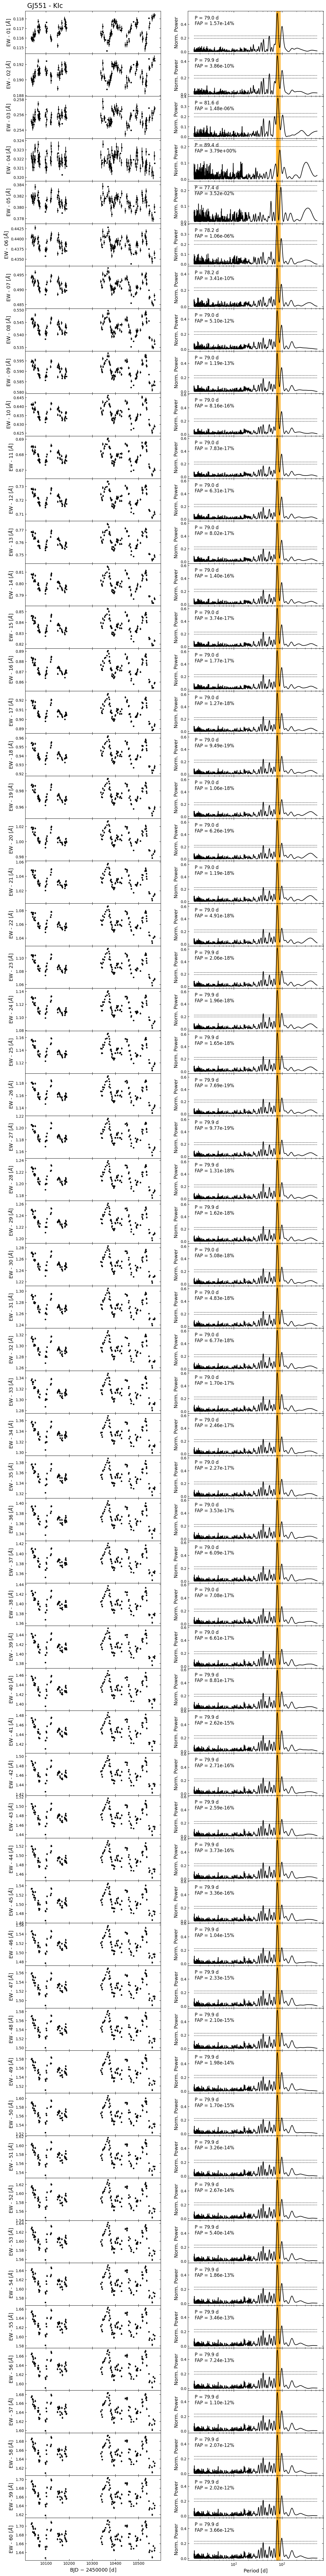

In [7]:
amaterasu = AMATERASU(star, data, indices, indice_info, 
                      gls_options, correlation_options,
                      output="full", 
                      fixed_bandpass=None, interp=True, plot_line=True, folder_path=f"amaterasu_tests")

Let's plot the period and FAP in function of central bandpass.

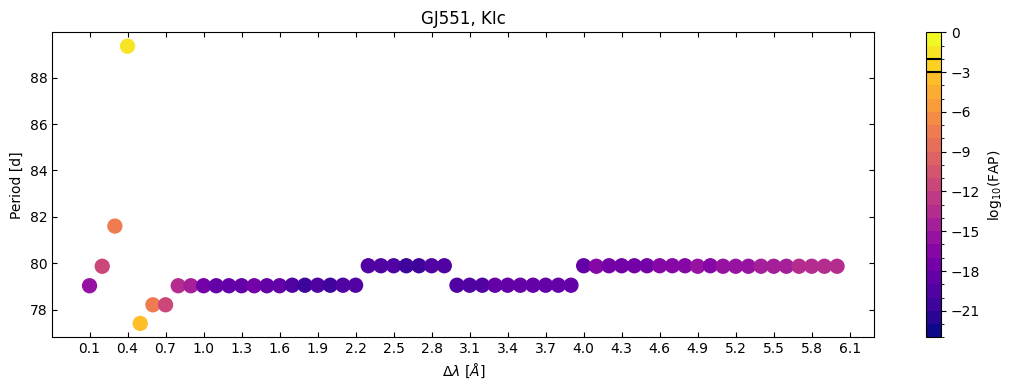

In [8]:
star = "GJ551"
indice = "KIc"

df_gls = pd.read_csv(f"amaterasu_tests/{star}/{indice}/periods_{star}_{indice}.csv")

cmap = plt.get_cmap("plasma")
log_FAP_min, log_FAP_max = 0, -23
boundaries = np.arange(log_FAP_max, log_FAP_min + 1, 1)  # Intervals of 1
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 4))

axes.set_title(f"{star}, {indice}")
sc1 = axes.scatter(df_gls["bandpass"], df_gls["period"], c=np.log10(df_gls["FAP"]), cmap=cmap, marker="o", s=100, norm=norm)

axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]"); axes.set_ylabel(r"Period [d]")
cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(FAP)")
cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

axes.set_xticks(np.arange(df_gls["bandpass"].min(),df_gls["bandpass"].max()+0.3,0.3))
axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
plt.tight_layout()
plt.show()

Or plot the correlation with FWHM of NIRPS CCF in function of central bandpass.

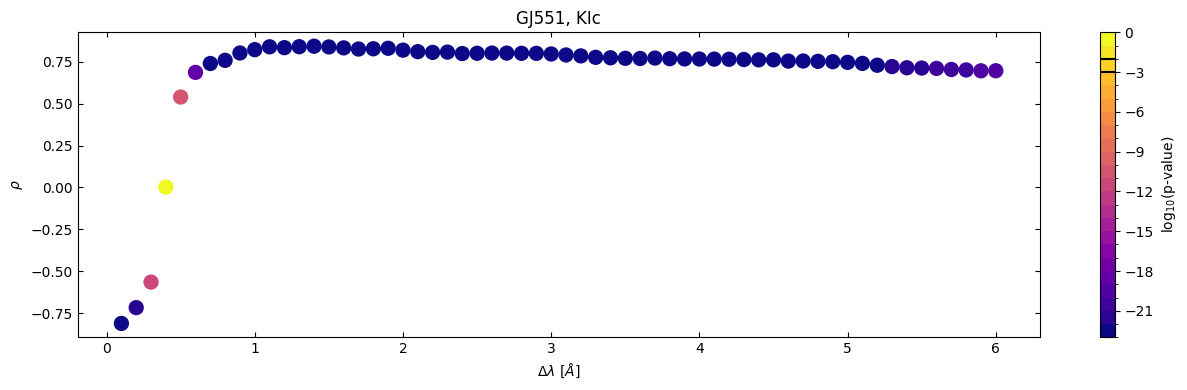

In [9]:
df_correlations = pd.read_csv(f"amaterasu_tests/{star}/{indice}/correlations_{star}_{indice}.csv")

cmap = plt.get_cmap("plasma")
log_pval_min, log_pval_max = 0, -23
boundaries = np.arange(log_pval_max, log_pval_min + 1, 1)  # Intervals of 1
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(13, 4))

axes.set_title(f"{star}, {indice}")
sc1 = axes.scatter(df_correlations["bandpass"], df_correlations["rho_fwhm"], c=np.log10(df_correlations["pval_fwhm"]), cmap=cmap, marker="o", s=100, norm=norm)

axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]")
axes.set_ylabel(r"$\rho$")
cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(p-value)")
cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

#axes.set_xticks(np.arange(df_correlations["bandpass"].min(),df_correlations["bandpass"].max()+0.3,0.3))
axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
plt.tight_layout()
plt.show()